In [0]:
  %pip install scalecast
  %pip install statsmodels


Python interpreter will be restarted.
  Using cached SCALECAST-0.18.8-py3-none-any.whl
  Using cached catboost-1.2-cp39-cp39-manylinux2014_x86_64.whl (98.6 MB)
  Using cached eli5-0.13.0-py2.py3-none-any.whl
  Using cached tbats-1.1.3-py3-none-any.whl (44 kB)
  Using cached dask-2023.7.1-py3-none-any.whl (1.2 MB)
  Using cached toolz-0.12.0-py3-none-any.whl (55 kB)
  Using cached partd-1.4.0-py3-none-any.whl (18 kB)
  Using cached importlib_metadata-6.8.0-py3-none-any.whl (22 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl (4.4 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Not uninstalling jinja2 at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-d5dd0616-b528-4147-997f-42a7f29bf58f
    Can't uninstall 'Jinja2'. No files were found to uninstall.
  Attempting uninstall: i

In [0]:
%run /Users/ebizindavyi@delhaize.be/Data_preparation/Parse_xls_files

In [0]:
from scalecast.Forecaster import Forecaster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scalecast.auxmodels import auto_arima
from lightgbm import LGBMRegressor
import datetime as dt

## Load the inbound data

In [0]:
inbound_2022_dir = '/dbfs/mnt/dataplatform/acc/DataScience/sandbox/ebiz/Inbound_FC/data/input/Ecom-Ops-status_2022.xlsx'

In [0]:
inbound_2022_df = create_master_df(inbound_2022_dir)

In [0]:
inbound_2022_df

,Dates,Dry Fc,Dry Actuals,Fresh Fc,Fresh,Frozen Fc,Frozen,Ultrafresh Fc,Ultrafresh
0,2022-01-03,85794.442754,84224.0,60969.286307,41000.0,49273.053738,5581.0,6538.217201,6538.217201
1,2022-01-04,65323.939111,49564.0,68517.000793,64233.0,6447.045743,6110.0,7288.014352,9673.000000
2,2022-01-05,59060.496963,45890.0,59891.490569,61162.0,14752.884950,6061.0,8645.127518,9394.000000
3,2022-01-06,54098.434315,26976.0,54044.997867,55700.0,11884.161805,5042.0,8733.406013,7299.000000
4,2022-01-07,48633.525710,37044.0,48691.064872,49534.0,7322.811052,5979.0,7745.598367,8240.000000
...,...,...,...,...,...,...,...,...,...
293,2022-12-27,71459.270000,63764.0,67049.998422,68912.0,6642.104962,5615.0,9028.927578,11033.000000
294,2022-12-28,71916.320000,47680.0,62406.358606,57239.0,5883.382433,5253.0,9509.601394,10525.000000
295,2022-12-29,60346.346000,39552.0,76619.568000,63748.0,5951.031775,6037.0,9399.318000,10458.000000
296,2022-12-30,52203.888000,61119.0,65006.548000,42234.0,5759.074282,6692.0,9096.132000,7824.000000


### Create yearly time series
needed to fill in date gaps

In [0]:
calendar_2022 = pd.DataFrame({'Dates':pd.date_range(dt.datetime(2022,1,3), periods=363, freq='d')})
inbound_2022_dry = calendar_2022.merge(inbound_2022_df, on='Dates',how='left').fillna(0).set_index('Dates').copy()
inbound_2022_dry = inbound_2022_dry.groupby(['Dates'])['Dry Actuals'].sum()
inbound_2022_dry

Out[18]: Dates
2022-01-03    84224.0
2022-01-04    49564.0
2022-01-05    45890.0
2022-01-06    26976.0
2022-01-07    37044.0
               ...   
2022-12-27    63764.0
2022-12-28    47680.0
2022-12-29    39552.0
2022-12-30    61119.0
2022-12-31    46818.0
Name: Dry Actuals, Length: 363, dtype: float64

## Create forecasting element

In [0]:
new_f_element = Forecaster(
    y = inbound_2022_dry,
    current_dates = inbound_2022_dry.index,
    future_dates = 14,
    cis = True,
    metrics = ['rmse','mae','mape','r2']
)

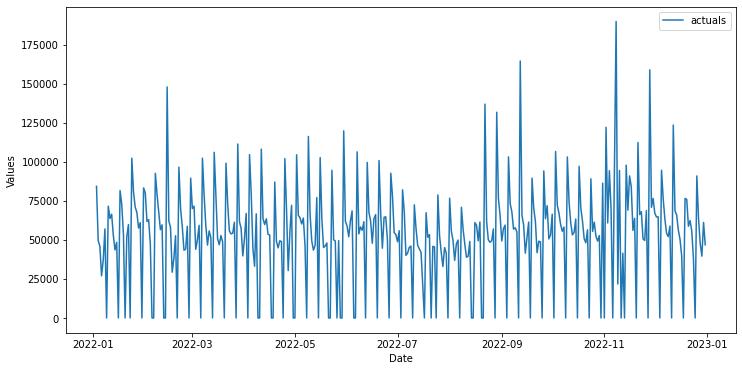

In [0]:
# display the entire series
new_f_element.plot()
plt.show()

check any seasonal or cyclic patterns existing in the data 

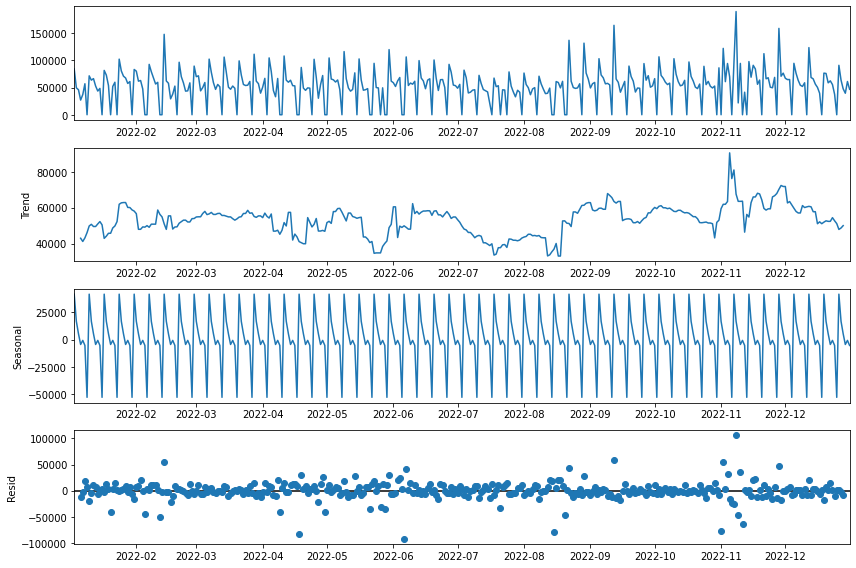

In [0]:
plt.rc("figure",figsize=(12,8))
new_f_element.seasonal_decompose().plot()
plt.show()

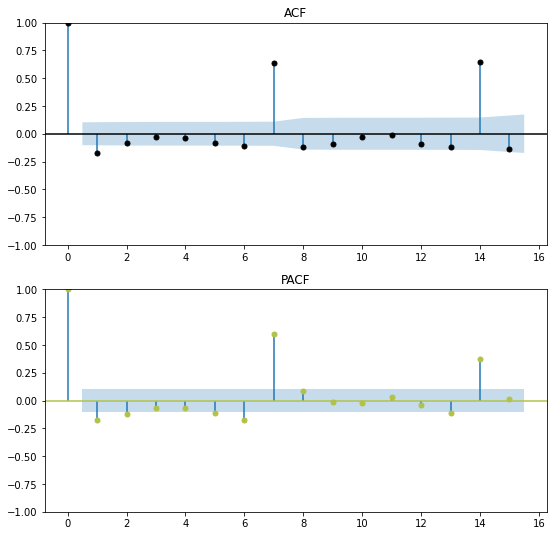

In [0]:
#mathematical proof
figs, axs = plt.subplots(2, 1,figsize=(9,9))
new_f_element.plot_acf(ax=axs[0],title='ACF',lags=15,color='black')
new_f_element.plot_pacf(ax=axs[1],title='PACF',lags=15,color='#B2C248',method='ywm')
plt.show()

### Set the parameters 
Paremetize the forecast objects, the more features and parameters we set, the more we help the model to better performance

In [0]:
new_f_element.set_test_length(.20)

In [0]:
new_f_element.set_validation_length(5)

In [0]:
new_f_element.set_validation_metric('mae')

In [0]:
new_f_element.eval_cis(
    mode = True,
    cilevel = .95,
)

In [0]:
new_f_element.add_seasonal_regressors(
'dayofweek',
'dayofyear',
'month',
'week',
'quarter',
raw=False,
sincos=True,
cycle_lens={'dayofyear':365.25},

)

In [0]:
new_f_element

Out[28]: Forecaster(
    DateStartActuals=2022-01-03T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=363
    ForecastLength=14
    Xvars=['dayofweeksin', 'dayofweekcos', 'dayofyearsin', 'dayofyearcos', 'monthsin', 'monthcos', 'weeksin', 'weekcos', 'quartersin', 'quartercos']
    TestLength=72
    ValidationMetric=mae
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [0]:
#Add autoregressive term, consider 
new_f_element.add_ar_terms(14)

In [0]:
new_f_element

Out[30]: Forecaster(
    DateStartActuals=2022-01-03T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=363
    ForecastLength=14
    Xvars=['dayofweeksin', 'dayofweekcos', 'dayofyearsin', 'dayofyearcos', 'monthsin', 'monthcos', 'weeksin', 'weekcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14']
    TestLength=72
    ValidationMetric=mae
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

### ARIMA model

In [0]:
%%time
auto_arima(new_f_element,test='adf',seasonal=True,dynamic_testing=14,m=7,error_action="ignore")

CPU times: user 3min 3s, sys: 3min 6s, total: 6min 10s
Wall time: 2min 26s


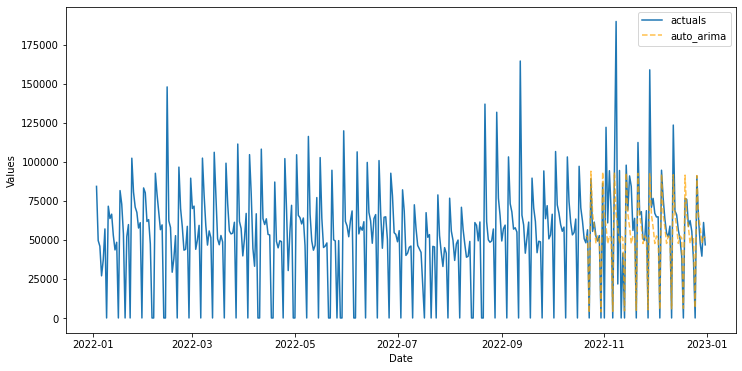

In [0]:
new_f_element.plot_test_set(models=['auto_arima'],ci=False,order_by='TestSetRMSE')
plt.show()

## lightgbm model 

In [0]:
%%time
new_f_element.set_estimator('lightgbm')
new_f_element.manual_forecast(max_depth=2,dynamic_testing=14)

CPU times: user 8.25 s, sys: 1.55 s, total: 9.8 s
Wall time: 10.1 s


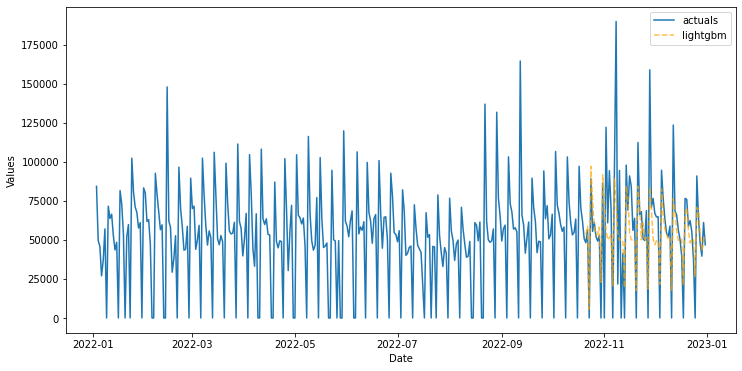

In [0]:
new_f_element.plot_test_set(models=['lightgbm'],ci=False,order_by='TestSetRMSE')
plt.show()

In [0]:
%%time
#max_depth= 3
new_f_element.set_estimator('lightgbm')
new_f_element.manual_forecast(call_me='lightgbm_2',max_depth=3,dynamic_testing=14)

CPU times: user 7.72 s, sys: 1.66 s, total: 9.38 s
Wall time: 9.57 s


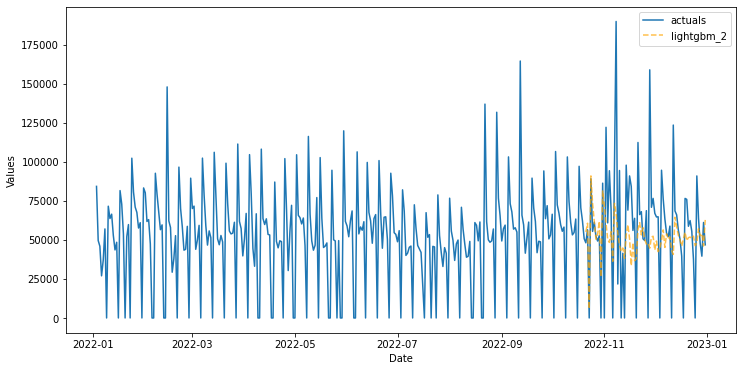

In [0]:
new_f_element.plot_test_set(models=['lightgbm_2'],ci=False)
plt.show()

In [0]:
%%time
#max_depth= 5
new_f_element.set_estimator('lightgbm')
new_f_element.manual_forecast(call_me='lightgbm_3',max_depth=5,dynamic_testing=14)

CPU times: user 8.71 s, sys: 1.6 s, total: 10.3 s
Wall time: 10.1 s


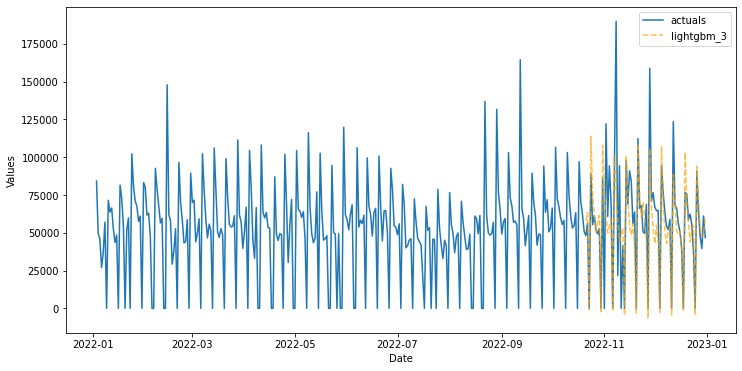

In [0]:
new_f_element.plot_test_set(models=['lightgbm_3'],ci=False)
plt.show()

### KNN model

In [0]:
%%time
# test the knn 
new_f_element.set_estimator('knn')
new_f_element.manual_forecast(n_neighbors=6,dynamic_testing=14)

CPU times: user 2.94 s, sys: 2.46 s, total: 5.4 s
Wall time: 8.12 s


Out[40]: <AxesSubplot:xlabel='Date', ylabel='Values'>

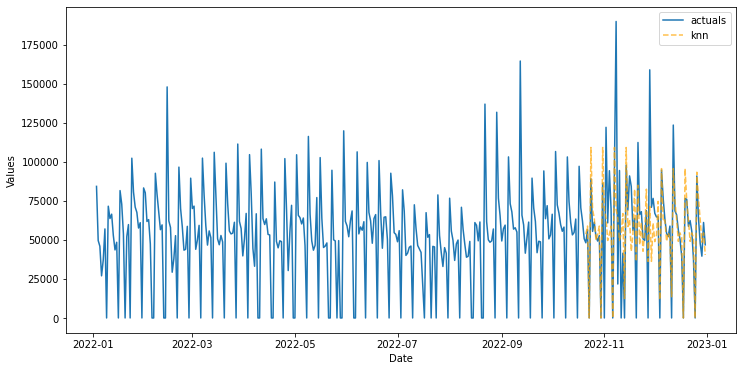

In [0]:
new_f_element.plot_test_set(models=['knn'],ci=False,order_by='TestSetRMSE')

In [0]:
new_f_element.set_estimator('knn')
new_f_element.manual_forecast(call_me='knn_2',n_neighbors=7,dynamic_testing=14)

Out[42]: <AxesSubplot:xlabel='Date', ylabel='Values'>

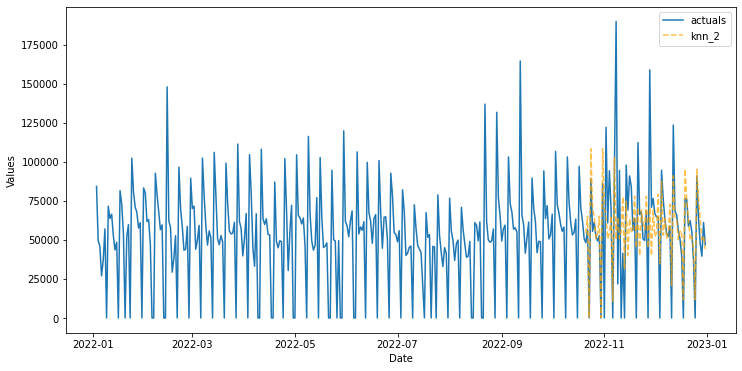

In [0]:
new_f_element.plot_test_set(models=['knn_2'],ci=False,order_by='TestSetRMSE')

In [0]:
%%time
new_f_element.set_estimator('knn')
new_f_element.manual_forecast(call_me='knn_3',n_neighbors=14,dynamic_testing=14)

CPU times: user 2.77 s, sys: 2.63 s, total: 5.41 s
Wall time: 7.35 s


Out[44]: <AxesSubplot:xlabel='Date', ylabel='Values'>

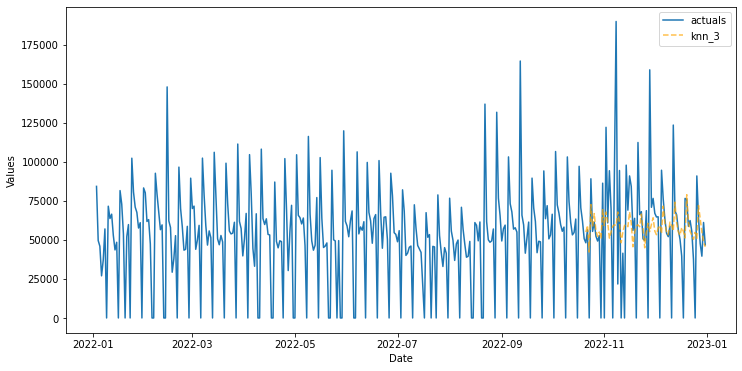

In [0]:
new_f_element.plot_test_set(models=['knn_3'],ci=False,order_by='TestSetRMSE')

In [0]:
%%time
new_f_element.set_estimator('knn')
new_f_element.manual_forecast(call_me='knn_4',n_neighbors=21,dynamic_testing=14)

CPU times: user 2.83 s, sys: 2.46 s, total: 5.29 s
Wall time: 7.58 s


Out[46]: <AxesSubplot:xlabel='Date', ylabel='Values'>

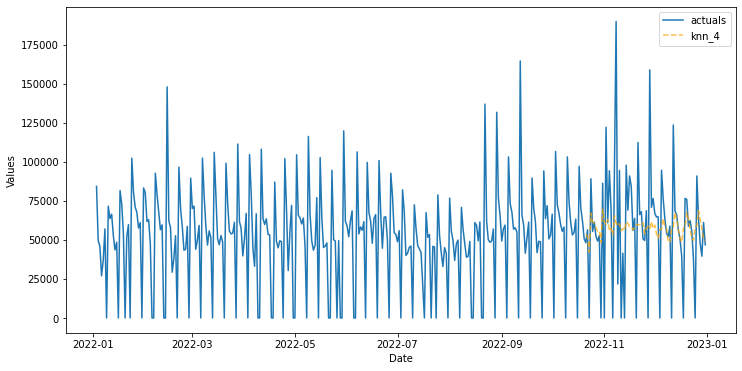

In [0]:
new_f_element.plot_test_set(models=['knn_4'],ci=False,order_by='TestSetRMSE')

Out[47]: <AxesSubplot:xlabel='Date', ylabel='Values'>

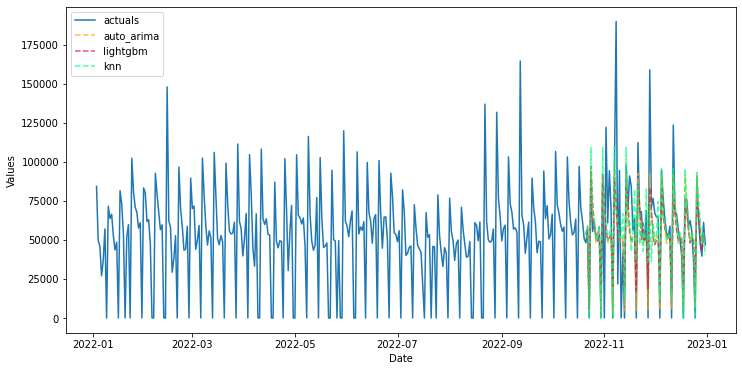

In [0]:
new_f_element.plot_test_set(models=['auto_arima','knn','lightgbm'],ci=False,order_by='TestSetRMSE')

In [0]:
new_f_element.export('model_summaries')

,ModelNickname,Estimator,Xvars,HyperParams,Observations,DynamicallyTested,TestSetLength,CILevel,ValidationMetric,ValidationMetricValue,models,weights,best_model,InSampleRMSE,InSampleMAE,InSampleMAPE,InSampleR2,TestSetRMSE,TestSetMAE,TestSetMAPE,TestSetR2
0,auto_arima,arima,None,"{'order': (1, 0, 0), 'seasonal_order': (2, 0, ...",363,1,72,0.95,NaN,NaN,NaN,NaN,True,20064.354289,12349.412478,NaN,0.616733,24819.066636,14450.584012,NaN,0.542018
1,lightgbm,lightgbm,"[dayofweeksin, dayofweekcos, dayofyearsin, day...",{'max_depth': 2},363,14,72,0.95,NaN,NaN,NaN,NaN,False,14838.881293,9181.449908,NaN,0.793921,26731.928327,17738.501358,NaN,0.468702
2,lightgbm_2,lightgbm,"[dayofweeksin, dayofweekcos, dayofyearsin, day...",{'max_depth': 3},363,14,72,0.95,NaN,NaN,NaN,NaN,False,11940.850725,7383.535559,NaN,0.866555,35102.776377,24890.481147,NaN,0.083862
3,lightgbm_3,lightgbm,"[dayofweeksin, dayofweekcos, dayofyearsin, day...",{'max_depth': 5},363,14,72,0.95,NaN,NaN,NaN,NaN,False,8387.694461,5133.435137,NaN,0.934156,25147.360276,15912.236978,NaN,0.529822
4,knn,knn,"[dayofweeksin, dayofweekcos, dayofyearsin, day...",{'n_neighbors': 6},363,14,72,0.95,NaN,NaN,NaN,NaN,False,18715.400657,10784.357938,NaN,0.672184,27182.156012,17301.387933,NaN,0.450654
5,knn_2,knn,"[dayofweeksin, dayofweekcos, dayofyearsin, day...",{'n_neighbors': 7},363,14,72,0.95,NaN,NaN,NaN,NaN,False,18710.468122,10769.778836,NaN,0.672357,29920.849050,19582.582040,NaN,0.334381
6,knn_3,knn,"[dayofweeksin, dayofweekcos, dayofyearsin, day...",{'n_neighbors': 14},363,14,72,0.95,NaN,NaN,NaN,NaN,False,21480.104342,13874.616923,NaN,0.568178,35753.866542,24423.957924,NaN,0.049562
7,knn_4,knn,"[dayofweeksin, dayofweekcos, dayofyearsin, day...",{'n_neighbors': 21},363,14,72,0.95,NaN,NaN,NaN,NaN,False,25688.893298,17725.618555,NaN,0.382378,35354.780371,24333.113253,NaN,0.070661


In [0]:
new_f_element.export('model_summaries').loc[0,'HyperParams']

Out[49]: {'order': (1, 0, 0), 'seasonal_order': (2, 0, 1, 7), 'trend': None}

### changing different parameters and add exogenous
add more hyperparameter, such as, depth of trees in lightGBM, Number of K neighbours in Knn, lag for patterns
